# Project: Artistic Neural Style Transfer

## Name: Clifton Mak Ren Ming

## ID: 29439701

#-------------------------------------------------------------------------------------------------------------------------

# Importing Libraries

In [1]:
import torch
import torch.nn as nn
from torch import optim   #gradient descent
import torchvision 
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from PIL import Image
import multiprocessing
#import torchvision.utils as vutils
import torchvision.models as models  #to get VGG 19 (pre-trained model)
import copy
from torchvision.utils import save_image

# Using Google drive

In [2]:
from google.colab import drive 
import sys 
import os
# Mount your Google drive to the VM
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/NN_project")

#set a root path variable to use
ROOT = "/content/gdrive/My Drive/NN_project"

#Follow link and give permission, copy code and paste in text box
#You only have to do this once per session

os.chdir("/content/gdrive/My Drive/NN_project")

Mounted at /content/gdrive


# Using GPU if available

In [3]:
#Taken from Lab 8
#torch.cuda.empty_cache()
#Set device to GPU if avaliable
GPU_indx = 0
use_cuda = torch.cuda.is_available()
device = torch.device(GPU_indx if use_cuda else "cpu")
torch.cuda.set_device(GPU_indx)

# Loading Style and Content Image

### Creating transform

In [4]:
RGBmean = (0.485,0.456,0.406)
RGBstd = (0.229, 0.224, 0.225)

#Resize can accept Pil or tensor
#transform_image =  transforms.Compose([transforms.Resize((512,512)),transforms.ToTensor(),transforms.Normalize(RGBmean,RGBstd)]) 
transform_image =  transforms.Compose([transforms.Resize((512,512)),transforms.ToTensor()]) 
transform_image2=  transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])

### Loading images

In [5]:
#Original image 
cat = Image.open('cat.jpg')
cat = torch.unsqueeze(transform_image(cat),0)   #dimension 0
cat = cat.to(device, torch.float)
gen_cat = cat.clone().requires_grad_(True)

#Style Image 
kandinsky = Image.open('kandinsky.jpg')
kandinsky = torch.unsqueeze(transform_image(kandinsky),0)   #dimension 0
kandinsky = kandinsky.to(device, torch.float)

In [6]:
## Referred to: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html#introduction

#Function to plot image

def plot_image(img,choice):
    img = img.cpu() #bring back to cpu from gpu
    img = img.clone() #cloning so we dont affect ori img
    img = img.squeeze(0)
    print(img.size())
    img = transforms.ToPILImage()(img)
    print(img)
    plt.figure(figsize = (5,5))
    plt.imshow(img)
    if choice == 1:
        plt.title('Style')
    elif choice == 2:
        plt.title('Content')

torch.Size([3, 512, 512])
<PIL.Image.Image image mode=RGB size=512x512 at 0x7F6858032F50>
torch.Size([3, 512, 512])
<PIL.Image.Image image mode=RGB size=512x512 at 0x7F6858032F10>


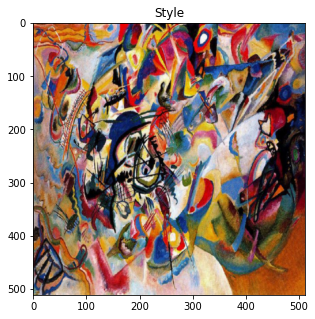

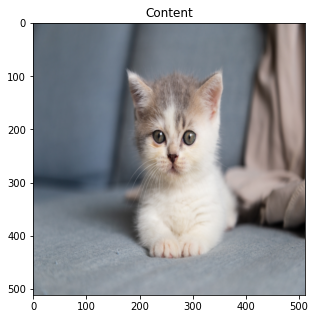

In [7]:
#Visualizing the images
plot_image(kandinsky,1)
plot_image(cat,2)


# Importing and Modifying VGG19 model

### Importing model

In [8]:
## Referred to: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html#introduction
# need only feautres. don't need the classifier part(fc layers)

vgg_model = models.vgg19(pretrained=True).features.to(device).eval()   #.eval to ignore gradient

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [9]:
print(vgg_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [10]:
#Referred to: https://towardsdatascience.com/implementing-neural-style-transfer-using-pytorch-fd8d43fb7bfa
#Referred to (change relu in-place to false): https://pytorch.org/tutorials/advanced/neural_style_tutorial.html#introduction
#Discussed with: Lim Wei Jun

def VGG_mod():
  model_ori = models.vgg19(pretrained=True)
  model_temp = model_ori

  #changing maxpool to avg pool
  for pos,feat in enumerate(model_temp.features):
    if isinstance(feat,nn.MaxPool2d):
      model_temp.features[pos] = nn.AvgPool2d(kernel_size = 2, stride = 2, padding = 0)
    
    if isinstance(feat,nn.ReLU):
      model_temp.features[pos] = nn.ReLU(inplace=False)
  
  return model_temp, model_ori


In [11]:
#Referred to: https://towardsdatascience.com/implementing-neural-style-transfer-using-pytorch-fd8d43fb7bfa
#Referred to: https://github.com/EugenHotaj/pytorch-generative/blob/master/notebooks/style_transfer.ipynb
#Discussed with: Lim Wei Jun

class VGG_style(nn.Module):
  def __init__(self):
    super(VGG_style,self).__init__()
    self.conv_layers = ['1','3','6','11','21','29']  #relu1_1,3_2, 2_1, 3_1, 4_1, 5_1
    self.model_ori, self.model_temp = VGG_mod() 
    self.mod_cnn = self.model_temp.features[:30]  #slicing everything after (29-1)

  def forward(self,x):
    extracted_feat = []  #array to store activations

    for pos,layer in enumerate(self.mod_cnn):
      x = layer(x) #

      if(str(pos) in self.conv_layers):
        extracted_feat.append(x)

        if (str(pos) == '1'):
          x = x*0.2
        elif (str(pos) == '6'):
          x = x*0.2
        elif (str(pos) == '11'):
          x = x*0.2
        elif (str(pos) == '21'):
          x = x*0.2
        elif (str(pos) == '29'):
          x = x*0.8
  
    return extracted_feat


  
class VGG_content(nn.Module):
  def __init__(self):
    super(VGG_content,self).__init__()
    self.conv_layers = ['14']  #relu3_2
    self.model_ori, self.model_temp = VGG_mod() 
    self.mod_cnn = self.model_temp.features[:15]  #slicing everything after (15-1)

  def forward(self,x):
    extracted_feat = []  #array to store activations

    for pos,layer in enumerate(self.mod_cnn):
      x = layer(x) #placing image into layer

      if(str(pos) in self.conv_layers):
        extracted_feat.append(x)
  
    return extracted_feat


# Defining Losses

### Content Loss

In [12]:
#Referred to: https://towardsdatascience.com/implementing-neural-style-transfer-using-pytorch-fd8d43fb7bfa
#Referred to: https://towardsdatascience.com/how-to-get-beautiful-results-with-neural-style-transfer-75d0c05d6489

def contentLoss(gen,ori):
    
    loss = F.l1_loss(gen,ori)
    
    return loss

### Gram matrix

In [13]:
#Referred to: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html#loss-functions

def gram_mat(x):
    b_size,depth,height,width = x.size() #depth is #of feature maps #b-size is batch size #height and width are dims of the 
                                                                                          #feature map
        
    x = x.view(b_size*depth, height*width)  #reshaping
    
    prod = torch.mm(x,x.t())  #.t is transpose
    
    num_elems = b_size*depth * height*width
    
    norm_G = prod.div(num_elems)    #normalize elements
    
    return norm_G

### Style loss

In [14]:
#Referred to: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html#loss-functions

def styleLoss(gen,style):
    
    gram_gen = gram_mat(gen)
    gram_style = gram_mat(style)
    
    loss = F.l1_loss(gram_gen,gram_style)
    
    return loss

### Total loss

In [15]:
#referred to: https://towardsdatascience.com/implementing-neural-style-transfer-using-pytorch-fd8d43fb7bfa
#alternative: zip allows iteration of multiple lists at the same time

def total_loss(gen,gen2,ori,style,cont_weight,style_weight):
  style_loss = 0
  content_loss = 0
  for i in range(len(gen)):
    style_loss += styleLoss(gen[i],style[i])
    
  
  content_loss = contentLoss(gen2[0],ori[0])
     
  
  tot = cont_weight*content_loss + style_weight*style_loss

  return tot,content_loss,style_loss


# Training model

### Defining hyperparameters and array

In [16]:
train_model_style = VGG_style().to(device).eval()
train_model_content = VGG_content().to(device).eval()

epochs_set = 2000
lr_set = 0.06  #0.04
cont_weight = 0.4
style_weight = 1e6
optimizer = optim.Adam([gen_cat],lr=lr_set)

tot_loss_logger = []  
cont_loss_logger = []  
style_loss_logger = []  


### Training

In [17]:

def train_model(model1,model2, optimizer, gen_img, ori_img, style_img, loss_func, loss_logger_tot,loss_logger_cont,loss_logger_style):
   
    #variable to track loss per epoch
    track_loss = 0
    
    #forward calc
    gen_feat = model1(gen_img)
    gen_feat2 = model2(gen_img)
    ori_feat = model2(ori_img)
    style_feat = model1(style_img)
    
    #Compute loss
    tot,content_loss,style_loss = loss_func(gen_feat,gen_feat2,ori_feat,style_feat,cont_weight,style_weight)
    
    #zero all gradients of the variables
    optimizer.zero_grad()
    
    #Backwards pass(to compute gradient loss)
    tot.backward()
    
    #update parameters
    optimizer.step()
    
    #log loss and acc
    loss_logger_tot.append(tot.item())
    loss_logger_cont.append(content_loss.item())
    #print(loss_logger_cont)
    loss_logger_style.append(style_loss.item())  
        
    return loss_logger_tot,loss_logger_cont, loss_logger_style,tot,content_loss,style_loss

In [18]:
for epoch in range(epochs_set):
    clear_output(True)
    print("Epoch: [%d/%d]" % (epoch+1, epochs_set))
    tloss_logger, closs_logger, sloss_logger, tot, content_loss, style_loss = train_model(train_model_style,train_model_content, optimizer, gen_cat, cat, kandinsky, total_loss, tot_loss_logger,cont_loss_logger,style_loss_logger)

    
    if (epoch%100 == 0):
        print("Saved image")
        file_name = "/image(epoch: %d).jpg" % epoch
        tot_str = ROOT + file_name
        save_image(gen_cat,tot_str)
        
    print("total loss: %.5f" % tot )
    print("content loss: %.5f" % content_loss )
    print("style loss: %.5f" % style_loss )

Epoch: [226/2000]


KeyboardInterrupt: ignored

# Plotting loss graph


In [ ]:
final_output = gen_cat
final_output = final_output.cpu().detach().numpy().squeeze(0)
#final_output = transforms.ToPILImage()(final_output)
final_output = np.moveaxis(final_output,0,2)
plt.imshow(final_output)
# plt.figure(figsize = (5,5))
# plt.imshow(final_output)

In [ ]:
def plot_loss(losses, show=True):
    fig = plt.gcf()
    fig.set_size_inches(8,6)
    ax = plt.axes()
    
    ax.set_title("Training average loss per epoch")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Average Loss")
    
    x_loss = list(range(len(losses)))
    plt.plot(x_loss, losses)

    if show:
        plt.show()

    plt.close()

In [ ]:
plot_loss(tloss_logger)